Let's get started, as before, with importing the necessary libraries and defining the environment.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.typing as npt
import typing
import gymnasium as gym
from dataclasses import dataclass
from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))


In [83]:
def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> tuple[list[npt.NDArray], list[int], list[float]]:
    """
    Collect a trajectory from the environment using the given policy
    """
    observations = []
    actions = []
    rewards = []
    obs, info = env.reset()
    
    while True:
        observations.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break

    return observations, actions, rewards

In [84]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

In [85]:
def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

In [86]:
# actor network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size 2
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, 2) # 256 -> 2

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mu = self.fc2(x)
        # sigma is fixed at 0.05
        sigma = 0.05*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

Here's the first large change. We need to define a **Critic**, also known as a **Value Network**. This is a neural network that will learn to predict the value $V^\pi(s)$ of a state $s$ under policy $\pi$. This is a regression problem, so we'll use a mean squared error loss function. We'll also use a separate optimizer for the critic, so we can tune its learning rate separately.

We use the same architecture for the critic as we did for the actor, except that the output layer has a single node with no activation function. This is because we want the critic to output a single value, not a probability distribution.

In [87]:
# critic network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size 1
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, 1) # 256 -> 1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x)) # Bx84x84x5 -> Bx20x20x16
        x = F.relu(self.conv2(x)) # Bx20x20x16 -> Bx9x9x32
        x = torch.flatten(x, start_dim=1) # Bx9x9x32 -> Bx9*9*32
        x = F.relu(self.fc1(x)) # Bx9*9*32 -> Bx256
        x = self.fc2(x) # Bx256 -> Bx1
        output = torch.squeeze(x, dim=1) # Bx1 -> B
        return output

In [88]:
def nn_policy(net:Actor, obs:npt.NDArray[np.float32]) -> tuple[float, float]:
    """
    A neural network policy that returns an action based on the given observation
    """
    # convert observation to a tensor
    obs_tensor = obs_batch_to_tensor([obs], deviceof(net))
    # sample from the policy network
    throttle, steer = net(obs_tensor).sample().squeeze(0)
    return throttle.item(), steer.item()

In [89]:
def rewards_to_go(trajectory_rewards: list[float], gamma) -> list[float]:
    """
    Computes the gamma discounted reward-to-go for each state in the trajectory.
    """

    trajectory_len = len(trajectory_rewards)

    v_batch = np.zeros(trajectory_len)

    v_batch[-1] = trajectory_rewards[-1]

    # Use gamma to decay the advantage
    for t in reversed(range(trajectory_len - 1)):
        v_batch[t] = trajectory_rewards[t] + gamma * v_batch[t + 1]

    return list(v_batch)

Our next task specific to PPO is to calculate advantage. Recall that advantage is defined as $A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s)$. However, in practice, the typical way to compute advantage is to use the GAE (Generalized Advantage Estimation) formula ([Schulman et al., 2015](https://arxiv.org/abs/1506.02438)):
$$
A_t^{GAE(\gamma,\lambda)} = \sum_{l=0}^\infty (\gamma\lambda)^l \delta_{t+l}
$$
where $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error. The GAE formula is a weighted combination of all possible TD errors, with more recent TD errors weighted more heavily. The parameters $\gamma$ and $\lambda$ control the discounting and the weighting of the TD errors. In practice, $\lambda$ is usually set to 0.95 or 0.99, and $\gamma$ is usually set to the same value as the discount rate used in the environment.

In our case, we set lambda to 1, enabling us to simplify the formula to:
$$
A_t^{GAE(\gamma,1)} = \sum_{l=0}^\infty \gamma^l \delta_{t+l}

In [90]:
def compute_advantage(
    critic: Critic,
    trajectory_observations: list[npt.NDArray[np.float32]],
    trajectory_rewards: list[float],
    gamma: float
) -> list[float]:
    """
    Computes advantage using GAE.

    See here for derivation: https://arxiv.org/abs/1506.02438
    """

    trajectory_len = len(trajectory_rewards)

    assert len(trajectory_observations) == trajectory_len
    assert len(trajectory_rewards) == trajectory_len

    # calculate the value of each state
    with torch.no_grad():
        obs_tensor = obs_batch_to_tensor(trajectory_observations, deviceof(critic))
        obs_values = critic.forward(obs_tensor).detach().cpu().numpy()

    # subtract the obs_value from the rewards-to-go
    trajectory_advantages = np.array(rewards_to_go(trajectory_rewards, gamma)) - obs_values

    return list(trajectory_advantages)

The following cell implements the core of the algorithm: the PPO-Clip loss and the training step:

In [91]:
@dataclass
class PPOConfig:
    ppo_eps: float
    ppo_grad_descent_steps: int

def compute_ppo_loss(
    # Old policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_thetak_given_st: torch.distributions.MultivariateNormal,
    # Current policy network's distribution of actions given a state
    # in (Batch, Action)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the old policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Advantage of the chosen action
    # in (Batch,)
    A_pi_thetak_given_st_at: torch.Tensor,
    # configuration options
    config: PPOConfig
) -> torch.Tensor:
    # the likelihood ratio (used to penalize divergence from the old policy)
    # in (Batch,)
    likelihood_ratio = torch.exp(pi_theta_given_st.log_prob(a_t) - pi_thetak_given_st.log_prob(a_t))

    # in (Batch,)
    ppo_loss_per_example = -torch.minimum(
        likelihood_ratio * A_pi_thetak_given_st_at,
        torch.clip(likelihood_ratio, 1 - config.ppo_eps, 1 + config.ppo_eps) * A_pi_thetak_given_st_at,
    )

    loss_per_example = ppo_loss_per_example

    # we take the average loss over all examples
    return loss_per_example.mean()

In [92]:
def compute_policy_gradient_loss(
    # Current policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Rewards To Go for the chosen action
    # in (Batch,)
    R_t: torch.Tensor,
) -> torch.Tensor:
    
    # in (Batch,)
    loss_per_example = -pi_theta_given_st.log_prob(a_t) * R_t

    # we take the average loss over all examples
    return loss_per_example.mean()


In [93]:
def kl_divergence(
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    pi_thetak_given_st: torch.distributions.MultivariateNormal,
    a_t: torch.Tensor
) -> torch.Tensor:
    log_pi_theta_given_st_at = pi_theta_given_st.log_prob(a_t)
    log_pi_thetak_given_st_at = pi_thetak_given_st.log_prob(a_t)

    kld = torch.mean(log_pi_theta_given_st_at - log_pi_thetak_given_st_at)
    print(f"KL divergence: {kld}")
    return kld

In [94]:
def train_ppo(
    actor: Actor,
    critic: Critic,
    actor_optimizer: torch.optim.Optimizer,
    critic_optimizer: torch.optim.Optimizer,
    observation_batch: list[npt.NDArray[np.float32]],
    action_batch: list[tuple[float, float]],
    advantage_batch: list[float],
    reward_to_go_batch: list[float],
    config: PPOConfig
) -> tuple[list[float], list[float]]:
    # assert that the models are on the same device
    assert deviceof(critic) == deviceof(actor)
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(advantage_batch)
    assert len(observation_batch) == len(reward_to_go_batch)

    # get device
    device = deviceof(critic)

    # convert data to tensors on correct device

    # in (Batch, Width, Height)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # the true V^pi(s) is reward to go
    # in (Batch,)
    true_value_batch_tensor = torch.tensor(
        reward_to_go_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # in (Batch,)
    advantage_batch_tensor = torch.tensor(advantage_batch, device=device)

    # # normalize advantage if it's too small
    # # we do this because in the beginning, the advantages are typically tiny (on the order of 1e-3)
    # # this means that ppo will not converge, even with 50 iterations.
    # # however, later, once we have a good policy, the advantages are on the order of 1e1, and it will converge
    # # therefore, we should normalize so that we have a good learning rate early on
    # advantage_batch_tensor = (advantage_batch_tensor - advantage_batch_tensor.mean()) / advantage_batch_tensor.std()

    # train critic
    critic_optimizer.zero_grad()
    pred_value_batch_tensor = critic.forward(observation_batch_tensor)
    critic_loss = F.mse_loss(pred_value_batch_tensor, true_value_batch_tensor)
    critic_loss.backward()
    critic_optimizer.step()

    # train actor

    # Recall that in the PPO algorithm, we need to set theta to the *optimal* theta with respect to the surrogate loss function,
    # as opposed to the standard policy gradient, where we just update theta.

    # Here's what that means:
    # We have a policy network with parameters theta_k
    # We want to find the optimal theta, theta*, that maximizes the surrogate loss function L_CLIP(theta, theta_k)
    # Note: In practice, we just use gradient descent for PPO_GRAD_DESCENT_STEPS steps to approximate theta*, since we can't analytically solve for theta*
    # We then update: theta_k <- theta*

    # The amount theta* can diverge from theta_k is limited by L_CLIP(theta, theta_k).
    # This is because we want to avoid the new policy diverging too far from the old policy, since that can lead to instability.

    # the old_policy_action_probs are the the predictions made by the pre-train-step network that we want to not diverge too far away from
    # in (Batch, Action)
    with torch.no_grad():
        old_policy_action_probs = actor.forward(observation_batch_tensor)

    actor_losses = []
    for _ in range(config.ppo_grad_descent_steps):
        actor_optimizer.zero_grad()
        current_policy_action_probs = actor.forward(observation_batch_tensor)
        actor_loss = compute_ppo_loss(
            old_policy_action_probs,
            current_policy_action_probs,
            chosen_action_tensor,
            advantage_batch_tensor,
            config
        )
        actor_loss.backward()
        actor_optimizer.step()
        actor_losses.append(float(actor_loss))


    # return the respective losses
    return actor_losses, [float(critic_loss)]*config.ppo_grad_descent_steps

In [95]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [96]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor  = Actor().to(device)
critic = Critic().to(device)

actor_optimizer = torch.optim.Adam(actor.parameters())
critic_optimizer = torch.optim.Adam(critic.parameters())

step = 0
returns = []
actor_losses = []
critic_losses = []

The training:

In [97]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 300, "num_scenarios": 100})

In [98]:
set_lr(actor_optimizer, 1e-5)
# the critic has to learn faster than the actor
set_lr(critic_optimizer, 3e-3)

TRAIN_EPOCHS = 200
EPISODES_PER_BATCH = 32
GAMMA = 0.80
CONFIG = PPOConfig(
    ppo_eps=0.1,
    ppo_grad_descent_steps=10,
)

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[npt.NDArray[np.float32]] = []
    act_batch:list[int] = []
    rtg_batch:list[float] = []
    adv_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        obs_traj, act_traj, rew_traj = collect_trajectory(env, lambda obs: nn_policy(actor, obs))
        rtg_traj = rewards_to_go(rew_traj, GAMMA)
        adv_traj = compute_advantage(critic, obs_traj, rew_traj, GAMMA)

        # Update batch
        obs_batch.extend(obs_traj)
        act_batch.extend(act_traj)
        rtg_batch.extend(rtg_traj)
        adv_batch.extend(adv_traj)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    batch_actor_losses, batch_critic_losses = train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        obs_batch,
        act_batch,
        adv_batch,
        rtg_batch,
        CONFIG,
    )

    # collect statistics
    returns.append(trajectory_returns)
    actor_losses.extend(batch_actor_losses)
    critic_losses.extend(batch_critic_losses)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Actor Loss: {actor_losses[-1]:.3f}, Critic Loss: {batch_critic_losses[-1]:.3f}")

    step += 1

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Step 0, Avg. Returns: 1.310 +/- 0.224, Median: 1.355, Actor Loss: -0.024, Critic Loss: 0.001
Step 1, Avg. Returns: 1.655 +/- 0.453, Median: 1.640, Actor Loss: 0.293, Critic Loss: 0.087
Step 2, Avg. Returns: 2.042 +/- 0.504, Median: 1.981, Actor Loss: 0.037, Critic Loss: 0.003
Step 3, Avg. Returns: 2.279 +/- 0.477, Median: 2.219, Actor Loss: -0.075, Critic Loss: 0.007
Step 4, Avg. Returns: 2.813 +/- 0.718, Median: 2.783, Actor Loss: -0.078, Critic Loss: 0.008
Step 5, Avg. Returns: 3.654 +/- 0.683, Median: 3.560, Actor Loss: -0.078, Critic Loss: 0.009
Step 6, Avg. Returns: 4.093 +/- 1.158, Median: 3.963, Actor Loss: -0.071, Critic Loss: 0.017
Step 7, Avg. Returns: 4.697 +/- 2.107, Median: 5.115, Actor Loss: -0.076, Critic Loss: 0.051
Step 8, Avg. Returns: 7.236 +/- 4.488, Median: 6.735, Actor Loss: -0.106, Critic Loss: 0.057
Step 9, Avg. Returns: 8.768 +/- 4.886, Median: 9.501, Actor Loss: -0.108, Critic Loss: 0.123
Step 10, Avg. Returns: 13.842 +/- 7.463, Median: 14.487, Actor Loss: -0.

In [ ]:
env.close()

Let's look at how the policy drives:

In [ ]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
obs, act, rew = collect_trajectory(env, lambda obs: nn_policy(actor, obs))
env.close()

print("Reward:", sum(rew))

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment


  logger.deprecation(
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 73.55717816658981


For us, we got returns of around 60-70 after training for 100 epochs.

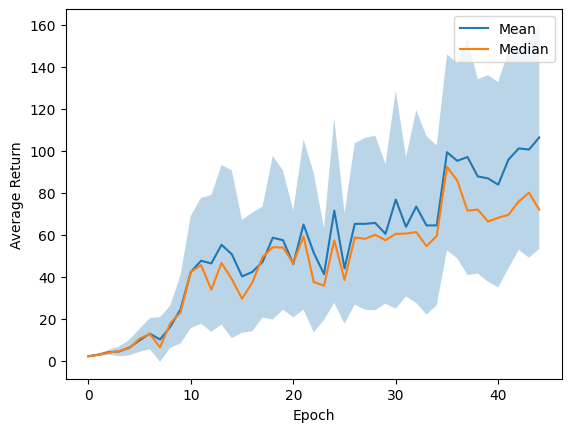

In [ ]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_means, label="Mean")
plt.plot(return_medians, label="Median")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

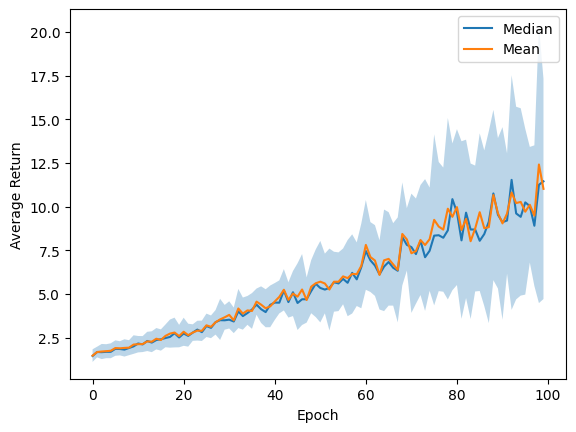

In [ ]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

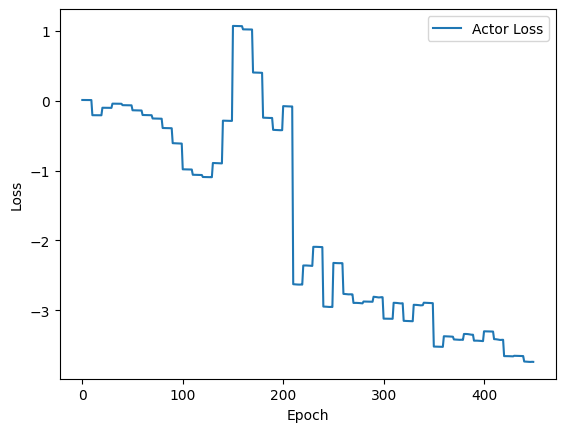

In [ ]:
# plot actor losses
plt.plot(actor_losses[:], label="Actor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

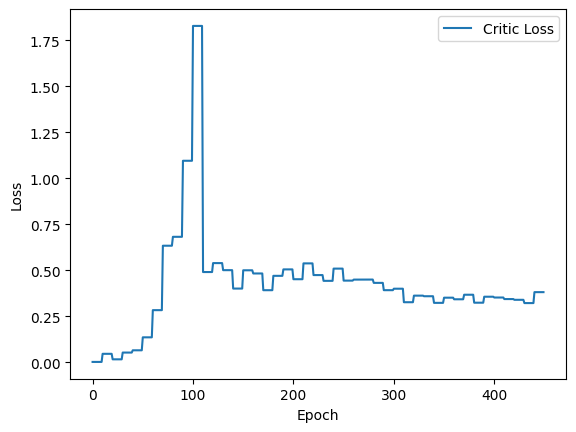

In [ ]:
# plot critic losses
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

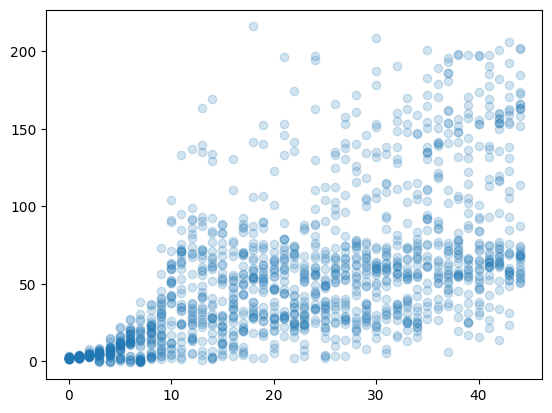

In [ ]:

# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.2)

In [ ]:
# print actual reward-to-go
print(np.array(rtg_traj))
# print predicted reward-to-go
print(critic.forward(obs_batch_to_tensor(obs_traj, deviceof(critic))).squeeze().detach().cpu().numpy())
# print advantage
print(np.array(adv_traj))

[ 0.24882486  0.31078701  0.37679998  0.43746852  0.49932226  0.56082262
  0.63127803  0.70716179  0.7861225   0.86058833  0.92955797  1.01092929
  1.09286391  1.17182892  1.25432685  1.33620481  1.41693983  1.49941552
  1.58615997  1.67015345  1.74863652  1.81886089  1.88796723  1.95345732
  2.01170328  2.06586487  2.11074909  2.15347513  2.19938174  2.24022385
  2.27595716  2.32684284  2.38523772  2.44675343  2.51190876  2.57354655
  2.63645211  2.7095161   2.77750867  2.84011781  2.89614665  2.95577949
  3.02781815  3.09414991  3.14892052  3.21433476  3.27958029  3.34233853
  3.41150483  3.48901613  3.56876244  3.63977337  3.70013069  3.74875989
  3.80441115  3.86371513  3.91883832  3.95378023  3.97821731  3.9947081
  4.01161247  4.02690017  4.02958993  4.0160966   3.98148877  3.93239083
  3.86575989  3.77891403  3.65925006  3.5124208   3.31632408  3.07893524
  2.76346559  2.36411948  1.87593114  1.27659316  0.5172288  -0.45079819
 -1.65625241 -3.14760668 -5.        ]
[1.3662269 1.3

In [ ]:
obs_example = obs[-1].transpose(2, 0, 1)

# obs_example has shape (5, 84, 84)
# plot each channel separately
for i in range(len(obs_example)):
    plt.imshow(obs_example[i])
    plt.show()


NameError: name 'obs' is not defined